### Data Reduction on Telescope Images - Caleb Wilkins 11/01/2021

In [1]:
#imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import h5py
plt.rcParams["figure.figsize"] = (20,15)

In this notebook we are going to work with a stack of telescope images. We have 10 images of one region of the night sky, and our goal will be to reduce the data in order to look for the faintest stars among the background. Let's plot one image and examine how spatially distributed it is, by summing the measurements row-wise and column-wise:

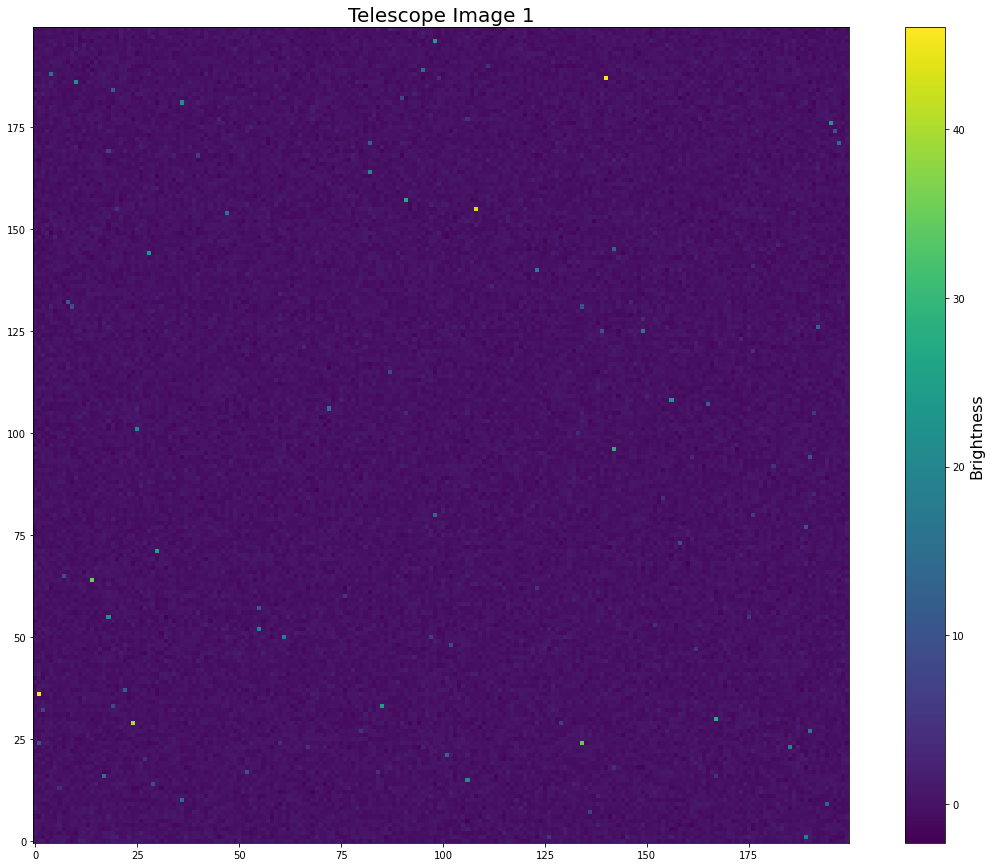

In [2]:
with h5py.File('images.h5', 'r') as hf:
    img_data = np.array(hf.get('imagestack'))

plt.title('Telescope Image 1', fontsize=20)
plt.imshow(img_data[:, :, 0], origin='lower')
plt.colorbar().set_label('Brightness', fontsize=16);

Further, we should plot the sums of the rows and columns in order to make sure our data is not too incredibly noisy such that we could not perform appropriate science with it.

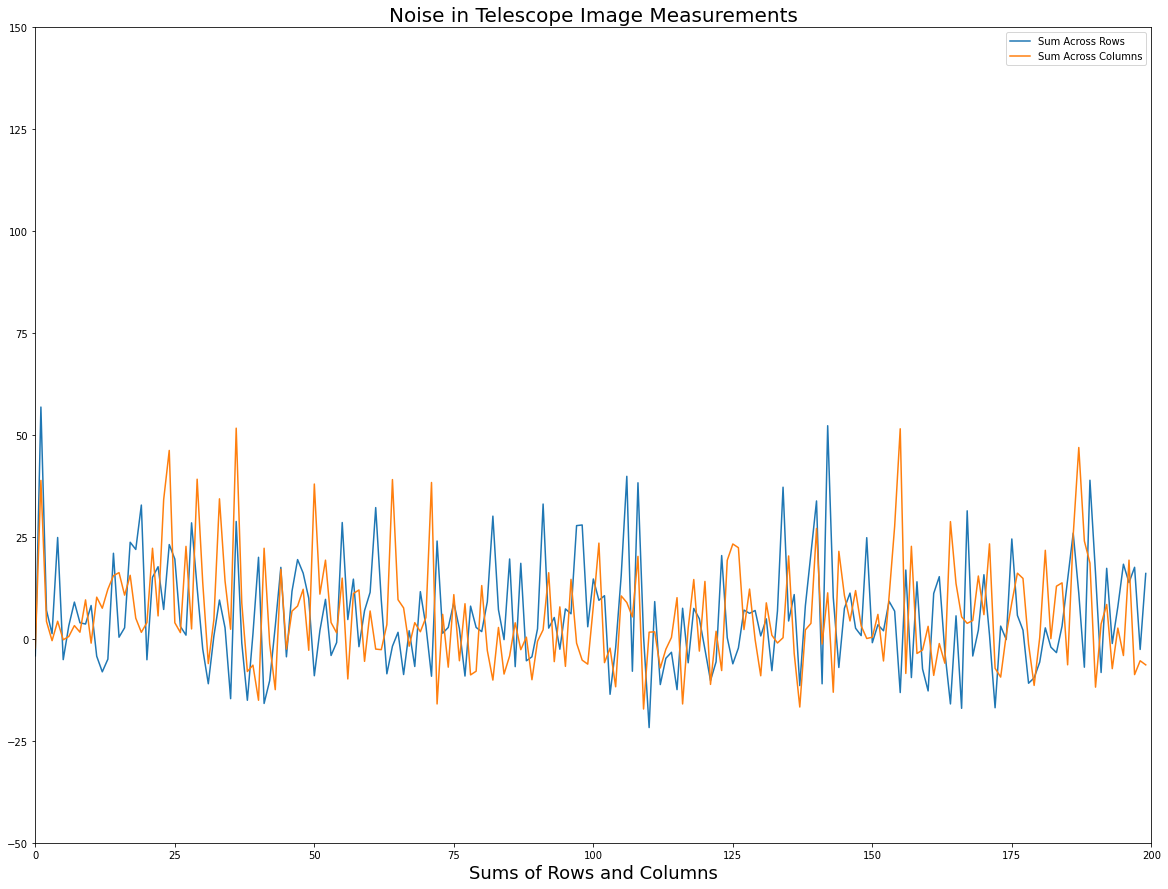

In [3]:
rows_sum = np.sum(img_data[:, :, 0], 0)
cols_sum = np.sum(img_data[:, :, 0], 1)
plt.plot(np.arange(0, 200), rows_sum)
plt.plot(np.arange(0, 200), cols_sum)
plt.xlabel('Sums of Rows and Columns', fontsize=18)
plt.xlim(0, 200)
plt.ylim(-50, 150)
plt.title('Noise in Telescope Image Measurements', fontsize=20)
plt.legend(['Sum Across Rows', 'Sum Across Columns']);

If we consider the distribution of the data spacially, it appears that Telescope Image 1 (as seen above) is relatively evenly distributed, given that the sum of measurements along each dimension of the image is an approximately constant line of noise. If we plot the 1-dimensional distribution of all the data in the image we should be able to find out if there is any signal contamination in our data (and if so, we can proceed with sorting out the cause of it).

Mean=0.00, Standard Deviation=0.56


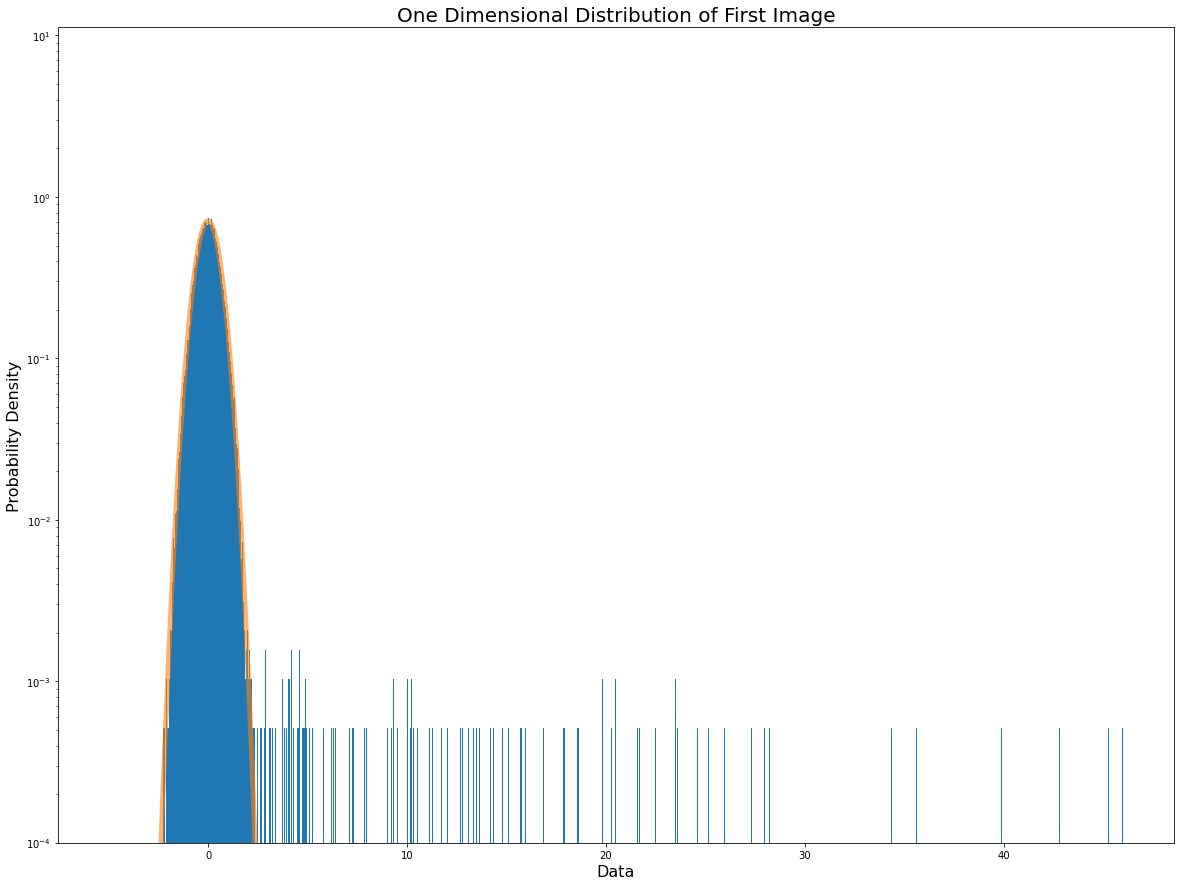

In [4]:
image1_data = img_data[:, :, 0].flatten()
relevant_data_1 = image1_data[image1_data < 2]
mean = np.mean(relevant_data_1)
std_dev = np.std(relevant_data_1)
x = np.linspace(-5, 5, 1000)
plt.xlabel('Data', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.title('One Dimensional Distribution of First Image', fontsize=20)
plt.yscale('log')
plt.ylim(1e-4, None)
plt.hist(image1_data, bins=1000, density=True)
plt.plot(x, stats.norm(mean, std_dev).pdf(x), linewidth=5, alpha=0.6)
print(f'Mean={abs(mean):.2f}, Standard Deviation={std_dev:.2f}');

We have some obvious signal contamination that can be seen as the probability increases out to measurements of 50 or more. However, for the most part the data of the first telescope image can be approximated as a Gaussian distribution with mean at 0 and a width of 0.56 units. When we consider the data of one image on its own, we can claim that the background is time independent since all the data was captured at the same time (as it's a photograph). We can't totally conclude that there is no time dependence in the complete data of all ten images since there was no information given on the time difference between when each image was taken. For simplification, we'll assume that there is no time dependence in the data of all ten images - or rather, that it is at least negligible because of the capabilities of modern devices to take many images in a very small amount of time. Since 0.56 units is a relatively large width if we're searching for very faint signals, we will average the distributions of all ten images together in order to reduce the width of the background.

Mean=0.00, Standard Deviation=0.18


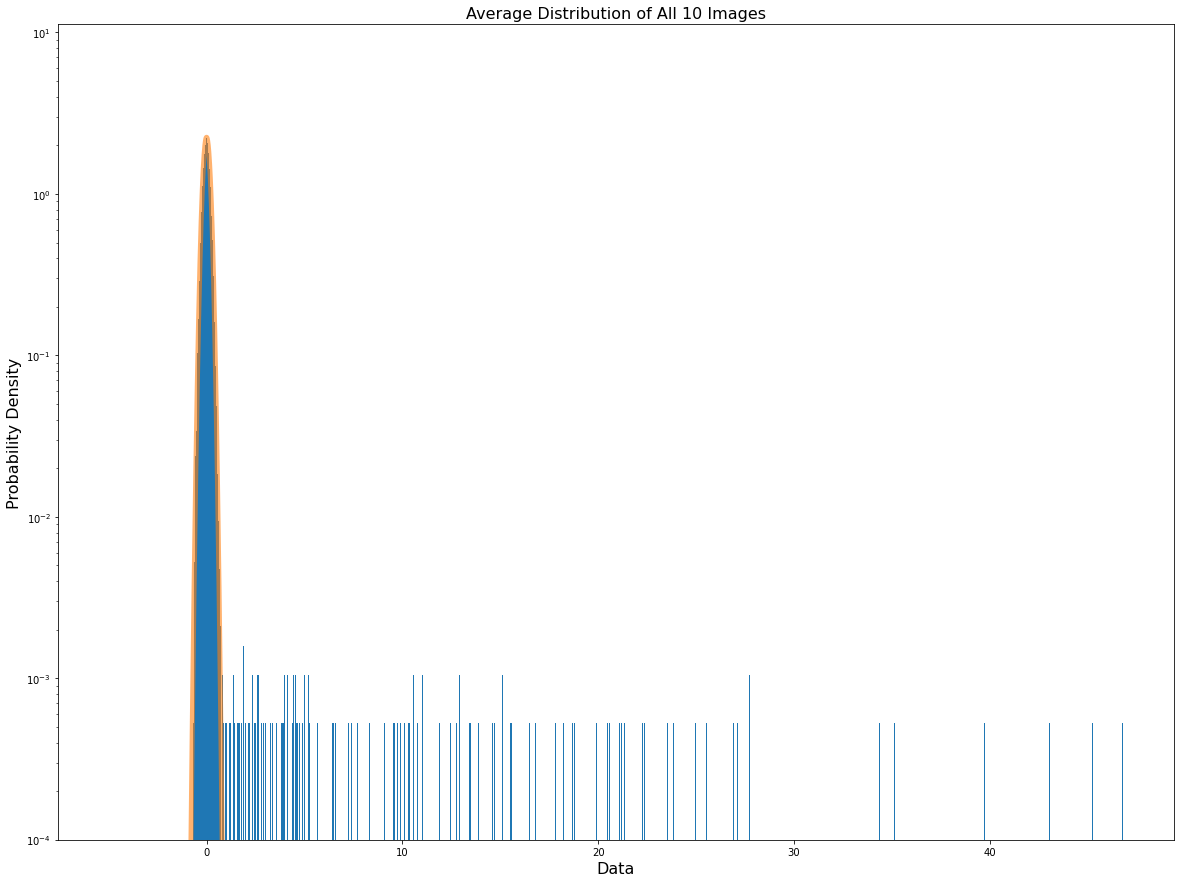

In [5]:
average_img = np.mean(img_data, axis=2)
relevant_data_avg = average_img[average_img < 1]
mean = np.mean(relevant_data_avg)
std_dev = np.std(relevant_data_avg)
x = np.linspace(-5, 5, 1000)
plt.xlabel('Data', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.title('Average Distribution of All 10 Images', fontsize=16)
plt.yscale('log')
plt.ylim(1e-4, None)
plt.hist(average_img.flatten(), bins=1000, density=True)
plt.plot(x, stats.norm(mean, std_dev).pdf(x), linewidth=5, alpha=0.6)
print(f'Mean={abs(mean):.2f}, Standard Deviation={std_dev:.2f}');

When we average the distributions of all ten images together, we get a background with mean still 0, but a width reduced by a factor of ~3. If we determine a 5-sigma threshold, we can know what signal threshold we need to be confident that the average background of 10 telescope images did not give us a significant signal.

In [6]:
threshold = stats.norm(mean, std_dev).ppf(stats.norm.cdf(5)).round(4)
print(threshold)

0.889


Thus, single measurements of 0.889 could be produced by the background, but an average measurement of 0.889 for 10 images is likely not produced by the background. So, to detect only the faintest stars we will restrict our search window to signals that are only slightly above 0.889 units.

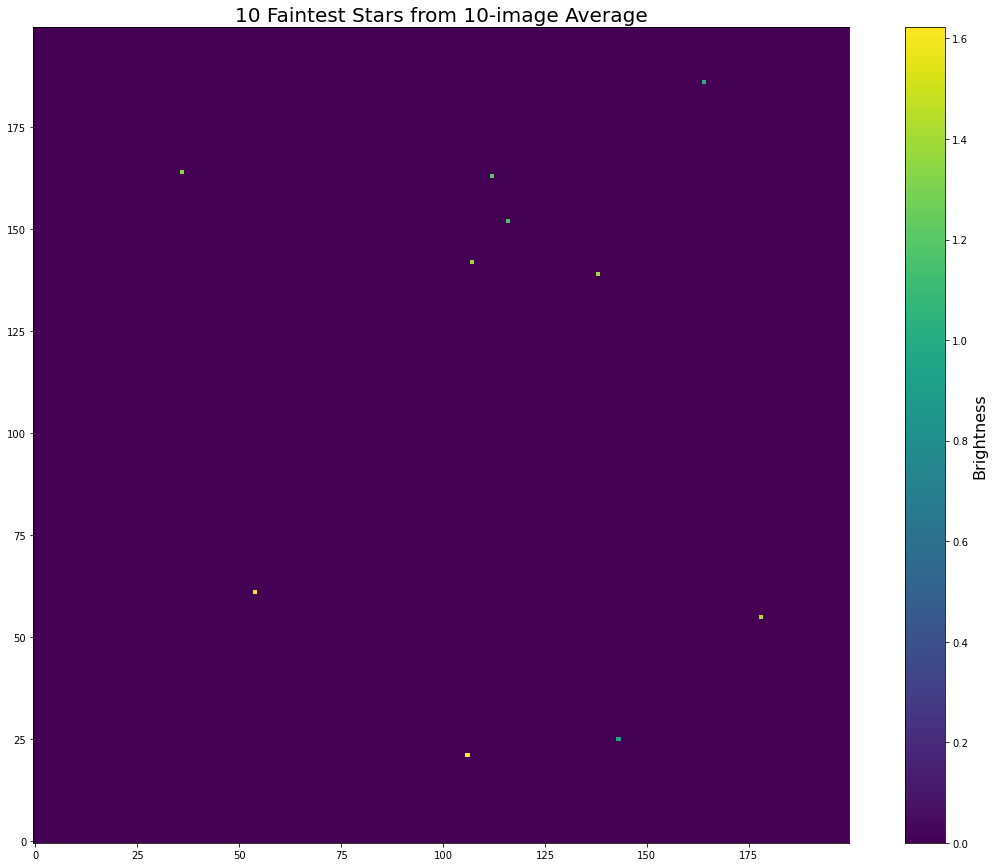

In [9]:
# I changed the delta value until I got the 10 faintest stars (arbitrary choice of faint star count)
delta = 0.8
detections = (average_img > threshold) & (average_img < threshold + delta)

plt.title('10 Faintest Stars from 10-image Average', fontsize=20)
plt.imshow(average_img * detections, origin='lower')
plt.colorbar().set_label('Brightness', fontsize=16);

Thus, we have successfully gone through the process of utilizing methods of data analysis, and subsequently data reduction, to plot the locations and brightnesses of the 10 faintest stars seen in this region of the sky.